In [1]:
# pip install python-mnist will install the required package
from mnist import MNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from threading import Thread
from operator import itemgetter

In [2]:
import torch
import torchvision                                 # datasets and transformations modules
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn                              # neural network module
import torch.nn.functional as F
import torch.optim as optim                        # optimization module
import torch.optim.lr_scheduler as lr_scheduler

# All networks derive from the base class nn.Module
class Perceptron(nn.Module):
    # get input and output dimensions as input
    def __init__(self, d, K):
        # all derived classes must call __init__ method of super class
        super(Perceptron, self).__init__()
        # create a fully connected layer from input to output
        self.model = nn.Linear(d, K)
    
    # forward method should get the input and return the output
    def forward(self,x):
        batch_size = x.shape[0]
        # flatten the image from BxCxHXW to Bx784
        x = x.view(batch_size, -1)
        x = self.model(x.float())
        # softmax is internally done inside cross entropy loss
        return x

In [3]:
class CustomGeneticForestClassifier:
    def __init__(self, N, generation_number, class_percentage):
        self.N = N
        self.generation_number = generation_number
        self.class_percentage = class_percentage
        self.trained_trees = []
        self.slp = None
        self.prediction_tree = None
        self.one_hot_encoder = None
        # torch parameters
        self.SEED = 0            # reproducability
        # NN Parameters
        self.EPOCHS = 20          # number of epochs
        self.LR = 0.01            # learning rate
        self.MOMENTUM = 0.9       # momentum for the optimizer
        self.WEIGHT_DECAY = 1e-5  # weight decay for the optimizer
        self.GAMMA = 0.1          # learning rate schedular
        self.BATCH_SIZE = 32      # number of images to load per iteration
        self.train_tree_batch = 20
        self.mutation_rate = 0.4
        self.population_list = None

    def train_net(self):
        # put the network in training mode
        self.slp.train()
        # keep record of the loss value
        epoch_loss = 0.0
        # use training data as batches
        for xt, rt in self.train_loader:
            # move training instances and corresponding labels into gpu if cuda is available
            xt, rt = xt.to(self.device), rt.to(self.device)
            # clear the previously accumulated gradients
            self.optimizer.zero_grad() 
            # forward the network
            yt = self.slp(xt)
            # calculate loss
            loss = self.loss_fn(yt, rt)
            # make a backward pass, calculate gradients
            loss.backward()
            # update weights
            self.optimizer.step()
            # accumulate loss
            epoch_loss += loss.item()
        return epoch_loss
        
    def train_tree(self, filter_label, state_counter, tree_list):
        
        y_train_subtree = self.y_train[self.y_train.label.isin(filter_label)]
        X_train_subtree = self.X_train.loc[y_train_subtree.index.values.tolist()]
        
        dtc = DecisionTreeClassifier(random_state=state_counter)
        dtc = dtc.fit(X_train_subtree,y_train_subtree)
        y_valid_filtered= self.y_valid[self.y_valid.label.isin(filter_label)]
        X_valid_filtered = self.X_valid.loc[y_valid_filtered.index]
        y_pred = dtc.predict(X_valid_filtered)
        tree_accuracy = metrics.accuracy_score(y_valid_filtered, y_pred)
        print("Accuracy of Tree",state_counter+1,":",tree_accuracy)
        print("Classes: ",filter_label)
        tree_list.append({"tree": dtc, "accuracy": tree_accuracy, "filter_label": filter_label})   
        
    def fit_trees(self, filter_labels, tree_list):
        state_counter = 0
        train_threads = []
        for filter_label in filter_labels:
            train_threads.append(Thread(target=self.train_tree, args=[filter_label, state_counter, tree_list]))
            state_counter += 1
        for thread_index in range(0, len(train_threads), self.train_tree_batch ):
            current_train_threads = train_threads[thread_index:thread_index+self.train_tree_batch ]
            for train_thread in current_train_threads:
                train_thread.start()
            for train_thread in current_train_threads:
                train_thread.join()
                
    def train_slp(self, one_hot_encoded_predictions):
        self.d = one_hot_encoded_predictions.shape[1]      # number of input features 
        
        print("SLP input dimension:", self.d)
        
        # manual seed to reproduce same resultsnet
        torch.manual_seed(self.SEED)
        # create the network
        self.slp = Perceptron(self.d,self.K)
        # check if CUDA is available
        cuda = torch.cuda.is_available()  
        self.device = torch.device("cuda:0" if cuda else "cpu")
        # if cuda is available move network into gpu
        self.slp.to(self.device)
        # specify the loss to be used
        # softmax is internally computed.
        self.loss_fn = nn.CrossEntropyLoss()
        # specify the optimizer to update the weights during backward pass
        self.optimizer = optim.SGD(self.slp.parameters(), lr=self.LR, momentum=self.MOMENTUM, weight_decay=self.WEIGHT_DECAY)
        # change learning rate over time
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=self.GAMMA) #CHECK THIS
        
        train_target = torch.tensor(self.y_train.values.flatten().astype(np.int32)).long()

        train = torch.tensor(one_hot_encoded_predictions) 

        train_tensor = torch.utils.data.TensorDataset(train, train_target) 
        self.train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = self.BATCH_SIZE, shuffle = True, num_workers=8)
        
        # train the network
        for epoch in range(1,self.EPOCHS+1):
            # train network for one epoch
            self.train_net()
        # print("SLP Weights:", self.slp.model.weight)
        
        
    def one_hot_encode(self):
        total_predictions = self.trained_trees[0].predict(self.X_train)
        for i in range(1, self.N):
            total_predictions = np.vstack([total_predictions, self.trained_trees[i].predict(self.X_train)])
        total_predictions = np.transpose(total_predictions)
        self.one_hot_encoder = OneHotEncoder(handle_unknown='ignore') 
        self.one_hot_encoder.fit(total_predictions)
        
        one_hot_encoded_predictions = self.one_hot_encoder.transform(total_predictions).toarray() 
        return one_hot_encoded_predictions

    
    def train_prediction_tree(self, one_hot_encoded_predictions):
        self.prediction_tree = DecisionTreeClassifier(random_state=200)
        self.prediction_tree = self.prediction_tree.fit(one_hot_encoded_predictions, self.y_train)
        
        
    def fit(self, X_train, y_train):
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)  # Train-test split pairs
        self.label_count = len(y_train.label.unique())
        self.sample_count = y_train.shape[0]
        self.K = self.label_count              # number of output features
        
        self.population_list = self.genetic_find_parameters()
        last_population = self.population_list[-1]
        
        self.trained_trees = [member['tree'] for member in last_population]
        
        one_hot_encoded_predictions = self.one_hot_encode()
        self.train_slp(one_hot_encoded_predictions)
        self.train_prediction_tree(one_hot_encoded_predictions)
        
    def model_analysis(self, X_train, y_train, X_test, y_test):
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)  # Train-test split pairs
        self.label_count = len(y_train.label.unique())
        self.sample_count = y_train.shape[0]
        self.K = self.label_count              # number of output features
        
        self.population_list = self.genetic_find_parameters()
        
        majority_accuracies = []
        slp_accuracies = []
        prediction_tree_accuracies = []
        population_mean_accuracies = []
        
        for population in self.population_list:
            
            population_mean_accuracy = np.mean(np.asarray([member['accuracy'] for member in population]))
            population_mean_accuracies.append(population_mean_accuracy)

            self.trained_trees = [member['tree'] for member in population]
            one_hot_encoded_predictions = self.one_hot_encode()
            self.train_slp(one_hot_encoded_predictions)
            self.train_prediction_tree(one_hot_encoded_predictions)
            
            majority_voting_pred = self.majority_voting_predict(X_test)
            slp_pred = self.slp_predict(X_test)
            prediction_tree_predict = self.prediction_tree_predict(X_test)
            
            majority_accuracy = metrics.accuracy_score(y_test, majority_voting_pred)
            slp_accuracy = metrics.accuracy_score(y_test, slp_pred)
            prediction_tree_accuracy = metrics.accuracy_score(y_test, prediction_tree_predict)
            
            majority_accuracies.append(majority_accuracy)
            slp_accuracies.append(slp_accuracy)
            prediction_tree_accuracies.append(prediction_tree_accuracy)
        
        generation_numbers = np.arange(len(self.population_list))
        
        
        plt.plot(generation_numbers, prediction_tree_accuracies, label = "Prediction Tree")
        plt.plot(generation_numbers, slp_accuracies, label = "SLP")
        plt.plot(generation_numbers, majority_accuracies, label = "Majority")
        plt.plot(generation_numbers, population_mean_accuracies, label = "Population Mean")
        plt.title("Accuracies in Generations")
        plt.xlabel("Generation Number")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
        
        
    
    def majority_voting_predict(self, X_test):
        total_predictions = self.forest_trees_predict(X_test)
        # Majority Voting
        predicted_values = []
        for row in total_predictions:
            majority_vote = np.bincount(row).argmax()
            predicted_values.append(majority_vote)
        y_pred_class = np.asarray(predicted_values)
        return y_pred_class
    
    def slp_predict(self, X_test):
        total_predictions = self.forest_trees_predict(X_test)
        # SLP
        one_hot_encoded_predictions = self.one_hot_encoder.transform(total_predictions).toarray() 
        test = torch.tensor(one_hot_encoded_predictions) 
        y_pred = self.slp(test.to(self.device))
        y_pred = y_pred.cpu().detach().numpy()
        y_pred_class = np.asarray([np.argmax(pred) for pred in y_pred])
        return y_pred_class
    
    def prediction_tree_predict(self, X_test):
        total_predictions = self.forest_trees_predict(X_test)
        # Prediction Tree
        one_hot_encoded_predictions = self.one_hot_encoder.transform(total_predictions).toarray() 
        y_pred_class = self.prediction_tree.predict(one_hot_encoded_predictions)
        return y_pred_class
    
    def forest_trees_predict(self, X_test):
        total_predictions = self.trained_trees[0].predict(X_test)
        for i in range(1, self.N):
            total_predictions = np.vstack([total_predictions, self.trained_trees[i].predict(X_test)])
        total_predictions = np.transpose(total_predictions)
        return total_predictions
    
    
    # Genetic algorithm  
    def generate_parent_samples(self):
        generation = []
        for i in range(self.N):
            generation.append(np.random.choice(range(self.label_count), round(self.label_count*self.class_percentage), replace=False))
        return generation  


    def genetic_find_parameters(self):
        generation = self.generate_parent_samples()
        population_list = []
        for i in range(self.generation_number+1):
            trained_tree_results = []
            self.fit_trees(generation, trained_tree_results)
            population_list.append(trained_tree_results)
            generation = self.evolve(trained_tree_results)
            print("Gen:",i)
        return population_list
    
        
    def evolve(self, trained_tree_results):
        
        trained_tree_results_sorted = sorted(trained_tree_results, key=itemgetter("accuracy"), reverse=True)
        
        next_generation = []
        
        # Elitism
        next_generation.append(trained_tree_results_sorted[0]["filter_label"])
        child_num = 1
        while(child_num < len(trained_tree_results)):
            parent_1 = self.tournament(trained_tree_results)
            parent_2 = self.tournament(trained_tree_results)
            child = self.crossover(parent_1, parent_2)
            self.mutate(child)
            if list(child) not in np.array(next_generation).tolist():          
                next_generation.append(child)
                child_num += 1         
        return next_generation

    
    def crossover(self, parent1, parent2):
        parents_merged = np.unique(np.append(parent1, parent2))
        child = np.random.choice(parents_merged, len(parent1), replace=False)
        return np.sort(child)

    
    def mutate(self, child):
        mutated_child = []
        if len(child) == self.label_count:
            return child
        non_existing_labels = []
        for label in range(self.label_count):
            if label not in child:
                non_existing_labels.append(label)
        for gen in child:
            if np.random.random() < self.mutation_rate:
                selected_label_index = np.random.randint(len(non_existing_labels))
                mutated_child.append(non_existing_labels.pop(selected_label_index))
            else:
                mutated_child.append(gen)
        return np.sort(mutated_child)

    def tournament(self, generation):
        # print("*********** Tournament ***********")
        accuracies = np.asarray([tree["accuracy"] for tree in generation])
        accuracies -= np.min(accuracies)
        probabilities = np.asarray(accuracies)/sum(accuracies)
        # print("Probabilities:",probabilities)
        selected = np.random.choice(generation, 1, p=probabilities)[0]["filter_label"]
        # print("Selected:", selected)
        return selected

In [4]:
np.random.seed(60) # reproducability

def mnist_dataset_read(path):
    mndata = MNIST(path)

    # read training images and corresponding labels
    tr_images, tr_labels = mndata.load_training()
    # read test images and corresponding labels
    tt_images, tt_labels = mndata.load_testing()

    # convert lists into numpy format and apply normalization
    tr_images = np.array(tr_images) / 255. # shape (60000, 784)
    tr_labels = np.array(tr_labels)         # shape (60000,)
    tt_images = np.array(tt_images) / 255. # shape (10000, 784)
    tt_labels = np.array(tt_labels)         # shape (10000,)

    columns_images = ['p{}'.format(i+1) for i in range(784)]
    X_train = pd.DataFrame(data=tr_images, columns=columns_images)
    y_train = pd.DataFrame(data=tr_labels, columns=['label'])
    X_test = pd.DataFrame(data=tt_images, columns=columns_images)
    y_test = pd.DataFrame(data=tt_labels, columns=['label'])
    return X_train, X_test, y_train, y_test

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data(btch):
    labels = btch[b'labels']
    imgs = btch[b'data'].reshape((-1, 32, 32, 3))
    
    res = []
    for ii in range(imgs.shape[0]):
        img = imgs[ii].copy()
        #img = np.transpose(img.flatten().reshape(3,32,32))
        img = np.fliplr(np.rot90(np.transpose(img.flatten().reshape(3,32,32)), k=-1))
        res.append(img)
    imgs = np.stack(res)
    return labels, imgs

def load_data_cifar():
    batch1 = unpickle("Datasets/cifar-10-batches-py/data_batch_1")
    batch2 = unpickle("Datasets/cifar-10-batches-py/data_batch_2")
    batch3 = unpickle("Datasets/cifar-10-batches-py/data_batch_3")
    batch4 = unpickle("Datasets/cifar-10-batches-py/data_batch_4")
    batch5 = unpickle("Datasets/cifar-10-batches-py/data_batch_5")
    test_batch = unpickle("Datasets/cifar-10-batches-py/test_batch")
    
    pixel_num = 32*32*3
    x_train_l = []
    y_train_l = []
    for ibatch in [batch1, batch2, batch3, batch4, batch5]:
        labels, imgs = load_data(ibatch)
        x_train_l.append(imgs)
        y_train_l.extend(labels)
    x_train = np.vstack(x_train_l)
    y_train = np.vstack(y_train_l)
    
    x_test_l = []
    y_test_l = []
    labels, imgs = load_data(test_batch)
    x_test_l.append(imgs)
    y_test_l.extend(labels)
    x_test = np.vstack(x_test_l)
    y_test = np.vstack(y_test_l)
    
    del batch1, batch2, batch3, batch4, batch5, test_batch
    
    # imgplot = plt.imshow(x_train[58])
    
    x_train, x_test = x_train.reshape(-1, pixel_num), x_test.reshape(-1, pixel_num)
    
    columns_images = ['p{}'.format(i+1) for i in range(pixel_num)]
    X_train = pd.DataFrame(data=x_train, columns=columns_images)
    y_train = pd.DataFrame(data=y_train, columns=['label'])
    X_test = pd.DataFrame(data=x_test, columns=columns_images)
    y_test = pd.DataFrame(data=y_test, columns=['label'])
    
    return X_train, y_train, X_test, y_test

In [12]:
def run_test(X_train, X_test, y_train, y_test):
    cgfc = CustomGeneticForestClassifier(N=5, generation_number=5, class_percentage = 0.5)
    cgfc.fit(X_train, y_train)
    slp_pred=cgfc.slp_predict(X_test)
    prediction_tree_pred=cgfc.prediction_tree_predict(X_test)
    majority_voting_pred=cgfc.majority_voting_predict(X_test)

    print("SLP Pred: ", metrics.accuracy_score(y_test, slp_pred))
    print("Prediction Tree Pred: ", metrics.accuracy_score(y_test, prediction_tree_pred))
    print("Majority Voting Pred: ", metrics.accuracy_score(y_test, majority_voting_pred))

In [7]:
m_X_train, m_X_test, m_y_train, m_y_test = mnist_dataset_read('Datasets/MNIST')
fm_X_train, fm_X_test, fm_y_train, fm_y_test = mnist_dataset_read('Datasets/Fashion_MNIST')
cf_X_train, cf_y_train, cf_X_test, cf_y_test = load_data_cifar()

Accuracy of Tree 2 : 0.8708493242115801
Classes:  [1 3 9 6 0]
Accuracy of Tree 4 : 0.8828843901622888
Classes:  [7 9 1 4 2]
Accuracy of Tree 3 : 0.8954900981860543
Classes:  [1 9 6 8 4]
Accuracy of Tree 5 : 0.9485610320873304
Classes:  [3 1 5 8 2]
Accuracy of Tree 1 : 0.9106786427145709
Classes:  [5 8 7 4 9]
Gen: 0
Accuracy of Tree 5 : 0.8820478500920194
Classes:  [1 2 4 7 9]
Accuracy of Tree 1 : 0.9449222626529937
Classes:  [3 1 5 8 2]
Accuracy of Tree 2 : 0.9469070459808138
Classes:  [1 2 3 5 8]
Accuracy of Tree 4 : 0.895173328910267
Classes:  [1 2 4 8 9]
Accuracy of Tree 3 : 0.9153359946773121
Classes:  [4 5 7 8 9]
Gen: 1
Accuracy of Tree 2 : 0.9506441358541075
Classes:  [1 2 5 7 8]
Accuracy of Tree 1 : 0.9449222626529937
Classes:  [1 2 3 5 8]
Accuracy of Tree 5 : 0.8949983438224578
Classes:  [1 2 4 5 8]
Accuracy of Tree 3 : 0.911681386435594
Classes:  [2 5 7 8 9]
Accuracy of Tree 4 : 0.9155023286759814
Classes:  [4 5 7 8 9]
Gen: 2
Accuracy of Tree 5 : 0.9490137077900368
Classes:  [

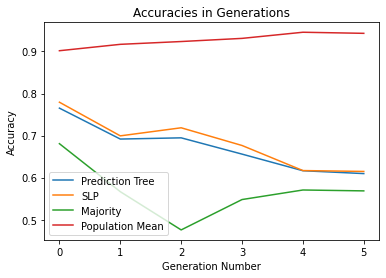

In [8]:
cgfc = CustomGeneticForestClassifier(N=5, generation_number=5, class_percentage = 0.5)
cgfc.model_analysis(fm_X_train, fm_y_train, fm_X_test, fm_y_test)

In [ ]:
# MNIST
print("MNIST\n")
run_test(m_X_train, m_X_test, m_y_train, m_y_test)

In [13]:
# Fashion MNIST
print("Fashion MNIST\n")
run_test(fm_X_train, fm_X_test, fm_y_train, fm_y_test)

Fashion MNIST

Accuracy of Tree 2 : 0.9354571096731376
Classes:  [1 0 5 3 9]
Accuracy of Tree 1 : 0.9458459468550285
Classes:  [9 7 8 0 1]
Accuracy of Tree 3 : 0.9145086321381142
Classes:  [1 9 0 4 3]
Accuracy of Tree 5 : 0.8666556782594363
Classes:  [3 2 4 9 8]
Accuracy of Tree 4 : 0.7590201919894075
Classes:  [2 8 6 4 3]
Gen: 0
Accuracy of Tree 1 : 0.9458459468550285
Classes:  [9 7 8 0 1]
Accuracy of Tree 5 : 0.9438277833837874
Classes:  [0 1 7 8 9]
Accuracy of Tree 3 : 0.9525790349417638
Classes:  [0 1 5 8 9]
Accuracy of Tree 4 : 0.8669853304763474
Classes:  [2 3 4 8 9]
Accuracy of Tree 2 : 0.9146442133069176
Classes:  [0 3 4 5 9]
Gen: 1
Accuracy of Tree 3 : 0.9372915276851234
Classes:  [1 3 5 7 8]
Accuracy of Tree 2 : 0.9456777665657585
Classes:  [0 1 7 8 9]
Accuracy of Tree 1 : 0.9517470881863561
Classes:  [0 1 5 8 9]
Accuracy of Tree 4 : 0.9172857850421
Classes:  [0 3 4 5 9]
Accuracy of Tree 5 : 0.9130289346044489
Classes:  [0 5 7 8 9]
Gen: 2
Accuracy of Tree 4 : 0.94046030687124

In [ ]:
# Cifar
print("Cifar\n")
run_test(cf_X_train, cf_X_test, cf_y_train, cf_y_test)